# Self supervised learning

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import torchvision.transforms.functional as tf

from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, random_split
from torch.autograd import Variable
from torchvision.models import resnet18
from torchvision.datasets import FashionMNIST, ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage, RandomHorizontalFlip, RandomCrop, ColorJitter, RandomResizedCrop, RandomRotation, \
    RandomAffine, Resize
from matplotlib import pyplot as plt
from random import randint
BATCH_SIZE=64

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
transform = Compose([Resize(32), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# FashionMNIST

In [20]:
class FashionMNISTDataset(Dataset):

    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index][0]
        target = self.targets[index][1]

        return data, target

In [21]:
ROOT_DIR = 'fashion_mnist'
TARGET_SIZE = 32
TRANSFORM = Compose([Resize(TARGET_SIZE), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
BATCH_SIZE = 128

# Download and load the training data
train_data = FashionMNIST(root=ROOT_DIR, download=True, train=True, transform=transform)
test_data = FashionMNIST(root=ROOT_DIR, download=True, train=False, transform=transform)

In [22]:
def train_val_subset(split):
    """Splits the train data in train and validation subsets."""
    data_set = train_data
    nbr_train_examples = int(len(data_set) * split)
    nbr_val_examples = len(data_set) - nbr_train_examples

    return random_split(data_set, [nbr_train_examples, nbr_val_examples])

In [23]:
def train_loader_fashion_mnist():
    """Creates the data loader for the train data."""
    train_subset, _ = train_val_subset(0.8)

    train_set = FashionMNISTDataset(
        data=train_subset,
        targets=train_subset
    )

    return DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [24]:
def val_loader_fashion_mnist():
    """Creates the data loader for the validation data."""
    _, val_subset = train_val_subset(0.8)

    val_set = FashionMNISTDataset(
        data=val_subset,
        targets=val_subset
    )

    return DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
def test_loader_fashion_mnist():
    """Creates the data loader for the test data."""
    return DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
train_set = train_data
val_set = val_loader_fashion_mnist()
test_set = test_data

print(len(train_set))
print(len(val_set))
print(len(test_set))


60000
94
10000


In [27]:
train_loader = train_loader_fashion_mnist()
val_loader = val_loader_fashion_mnist()
test_loader = test_loader_fashion_mnist()

for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys)
    break    
    
for xs, ys in val_loader:
    print(xs.size(), ys.size())
    print(ys)
    break

for xs, ys in test_loader:
    print(xs.size(), ys.size())
    print(ys)
    break        

torch.Size([128, 1, 32, 32]) torch.Size([128])
tensor([1, 0, 3, 1, 4, 5, 2, 2, 1, 3, 3, 0, 9, 2, 4, 5, 0, 5, 6, 5, 4, 9, 2, 4,
        7, 7, 9, 3, 6, 9, 9, 6, 1, 4, 6, 1, 1, 6, 8, 8, 2, 2, 8, 2, 0, 0, 0, 3,
        8, 0, 7, 5, 1, 8, 2, 9, 5, 4, 2, 3, 0, 6, 1, 6, 9, 8, 9, 9, 0, 0, 0, 6,
        0, 8, 4, 2, 5, 9, 6, 1, 7, 7, 9, 6, 8, 1, 4, 9, 1, 1, 0, 7, 0, 1, 4, 1,
        1, 9, 1, 4, 8, 1, 2, 7, 6, 9, 7, 3, 0, 4, 5, 6, 7, 5, 9, 4, 3, 5, 6, 8,
        2, 4, 9, 1, 2, 0, 9, 1])
torch.Size([128, 1, 32, 32]) torch.Size([128])
tensor([0, 4, 7, 0, 6, 1, 9, 6, 7, 5, 6, 4, 8, 6, 1, 4, 0, 5, 8, 6, 1, 8, 1, 5,
        3, 6, 2, 6, 8, 2, 8, 1, 6, 9, 4, 5, 3, 4, 4, 9, 6, 5, 1, 7, 9, 6, 0, 8,
        5, 2, 1, 3, 3, 3, 9, 3, 9, 3, 1, 7, 1, 7, 1, 1, 8, 5, 3, 1, 9, 5, 9, 8,
        2, 6, 3, 3, 7, 9, 8, 6, 1, 7, 9, 8, 1, 0, 4, 4, 1, 9, 2, 3, 5, 2, 1, 5,
        0, 6, 8, 7, 4, 1, 5, 5, 2, 8, 9, 6, 6, 9, 7, 4, 4, 0, 1, 7, 3, 0, 5, 1,
        6, 8, 1, 3, 4, 7, 3, 2])
torch.Size([128, 1, 32, 32]) torch.Size(

## Rotation

In [13]:
def rotate(image, angle):
    """Rotate the image by the specified angle"""
    image = tf.to_pil_image(image)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    image = tf.normalize(image, (0.5,), (0.5,))
    return image

torch.Size([256, 1, 32, 32])
torch.Size([256])


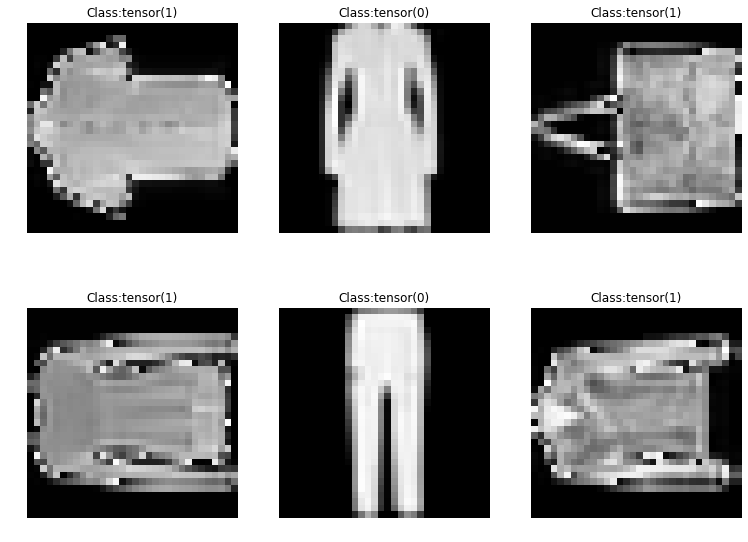

In [14]:
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    images_rotated = []
    labes_rotated = []

    for img in images:
        rotated_imgs = [
            img,
            rotate(img, 90),
            rotate(img, 180),
            rotate(img, 270)
        ]
        rotation_labels = torch.LongTensor([0, 1, 2, 3])
        stack = torch.stack(rotated_imgs, dim=0)

        images_rotated.append(stack)
        labes_rotated.append(rotation_labels)

    images = torch.cat(images_rotated, dim=0)
    labels = torch.cat(labes_rotated, dim=0)
    print(images.shape)
    print(labels.shape)
    
    f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
    axes = [ax for axs in axes for ax in axs]

    for i in range(6):
        index = randint(0, len(images))
        image = images[index]
        label = labels[index]
        axes[i].imshow(image[0].view(32, 32), cmap='gray')
        axes[i].set_title('Class:' + str(label))
        axes[i].axis('off')  
    
    break

## Exemplar CNN

In [15]:
def horizontal_flip(image):
    """Flip image horiontally."""
    transform = Compose([
        RandomHorizontalFlip(p=1.0),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_crop(image):
    """Crop Image."""
    transform = Compose([
        RandomCrop((20, 20)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def color_jitter(image):
    """Apply color jitter."""
    transform = Compose([
        ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.02),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_resized_crop(image):
    """Randomly resize and crop image."""
    transform = Compose([
        RandomResizedCrop(40, scale=(0.2, 1.0), ratio=(0.75, 1.333)),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_rotation(image):
    """Randomly rotate image."""
    transform = Compose([
        RandomRotation(45),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img


def random_affine_transformation(image):
    """Applies a random affine transformation to the image."""
    transform = Compose([
        RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.3), shear=10),
        Resize(32),
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    img = transform(image)
    return img

In [16]:
def transform_image(image, transformation):
    """Randomly transforms one image."""
    transform = ToPILImage()
    img = transform(image.cpu())

    if transformation == 0:
        return horizontal_flip(img)
    if transformation == 1:
        return random_crop(img)
    if transformation == 2:
        return color_jitter(img)
    if transformation == 3:
        return random_resized_crop(img)
    if transformation == 4:
        return random_rotation(img)
    if transformation == 5:
        return random_affine_transformation(img)

torch.Size([384, 1, 32, 32])
torch.Size([384])


IndexError: index 384 is out of bounds for dimension 0 with size 384

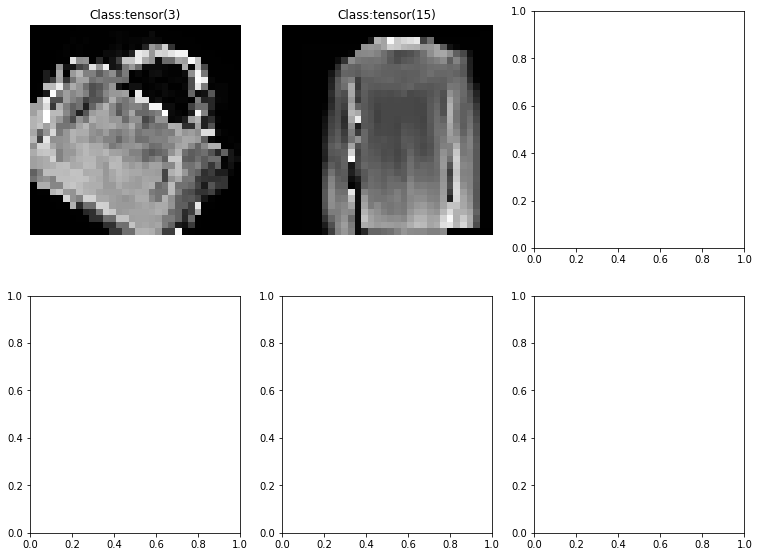

In [17]:
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    images_transformed = []
    labes_transformed = []

    for index, img in enumerate(images):
        transformed_imgs = [
            transform_image(img, 0),
            transform_image(img, 1),
            transform_image(img, 2),
            transform_image(img, 3),
            transform_image(img, 4),
            transform_image(img, 5),
        ]
        transformed_labels = torch.LongTensor([index, index, index, index, index, index])
        stack = torch.stack(transformed_imgs, dim=0)

        images_transformed.append(stack)
        labes_transformed.append(transformed_labels)

    images = torch.cat(images_transformed, dim=0)
    labels = torch.cat(labes_transformed, dim=0)
    print(images.shape)
    print(labels.shape)
    
    f, axes = plt.subplots(2, 3, figsize=(12.8, 9.6))
    axes = [ax for axs in axes for ax in axs]

    for i in range(6):
        index = randint(0, len(images))
        image = images[index]
        label = labels[index]
        axes[i].imshow(image[0].view(32, 32), cmap='gray')
        axes[i].set_title('Class:' + str(label))
        axes[i].axis('off')  
    
    break

## DeepFashion

In [30]:
from torch.utils.data import Dataset

class DeepFashionDataset(Dataset):

    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        datapoint = self.data[index][0]
        target = self.target[index]

        return datapoint, target

In [31]:
ROOT_DIR = '../img/'
TARGET_SIZE = (32, 32)
BATCH_SIZE = 64

In [34]:
def load_images():
    """Load the images from the root directory."""
    transforms = Compose([
        Resize(TARGET_SIZE),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])
    return ImageFolder(ROOT_DIR, transform=transforms)

In [192]:
images = load_images()
print(len(images))

289219


In [35]:
def load_list_category_img():
    """Load the list containing the image name and the associated category."""
    list_category_img = pd.read_csv('../list_category_img.txt', sep="\t", header=0)
    list_category_img.columns = ["image_name", "category_label"]
    return list_category_img


In [36]:
def load_list_category_cloth():
    """Load the list containing the category name and the associated category type."""
    list_category_cloth = pd.read_csv('../list_category_cloth.txt', sep="\t", header=0)
    list_category_cloth.columns = ["category_name", "category_type"]
    return list_category_cloth


In [37]:
def load_list_eval_partition():
    """Load the list containing the image name and the associated evaluation status."""
    list_eval_partition = pd.read_csv('../list_eval_partition.txt', sep="\t", header=0)
    list_eval_partition.columns = ["image_name", "evaluation_status"]
    return list_eval_partition

In [38]:
def train_data():
    """Return the images with the evaluation status 'train'."""
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    train_indices = partition[partition.evaluation_status == 'train'].index
    train_images = Subset(images, train_indices)
    train_labels = labels.category_label[train_indices].values

    return DeepFashionDataset(train_images, train_labels)

In [39]:
def val_data():
    """Return the images with the evaluation status 'val'."""
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    val_indices = partition[partition.evaluation_status == 'val'].index
    val_images = Subset(images, val_indices)
    val_labels = labels.category_label[val_indices].values
    return DeepFashionDataset(val_images, val_labels)

In [40]:
def test_data():
    """Return the images with the evaluation status 'test'."""
    images = load_images()
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    test_indices = partition[partition.evaluation_status == 'test'].index
    print(test_indices)
    print(images[289216])
    print(len(test_indices))
    test_images = Subset(images, test_indices)
    test_labels = labels.category_label[test_indices].values
    return DeepFashionDataset(test_images, test_labels)


In [41]:
def train_loader_deep_fashion():
    """Return the data loader for the train data."""
    return DataLoader(train_data(), batch_size=BATCH_SIZE, shuffle=True)

In [42]:
def val_loader_deep_fashion():
    """Return the data loader for the validation data."""
    return DataLoader(val_data(), batch_size=BATCH_SIZE, shuffle=False)

In [43]:
def test_loader_deep_fashion():
    """Return the data loader for the test data."""
    return DataLoader(test_data(), batch_size=BATCH_SIZE, shuffle=False)

In [44]:
for images, labels in train_loader_deep_fashion():
    images = images
    labels = labels

    print(images.shape)
    print(labels.shape)
    
    images_rotated = []
    labes_rotated = []
    
    for index, img in enumerate(images):
        rotated_imgs = [
            img,
            rotate(img, 90),
            rotate(img, 180),
            rotate(img, 270)
        ]
        rotation_labels = torch.LongTensor([0, 1, 2, 3])
        stack = torch.stack(rotated_imgs, dim=0)

        images_rotated.append(stack)
        labes_rotated.append(rotation_labels)

    images = torch.cat(images_rotated, dim=0)
    labels = torch.cat(labes_rotated, dim=0)
    print(labels)
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])
tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([256, 3, 32, 32])
torch.Size([256])


In [147]:
def default_loader(path):
    return Image.open(path)

In [107]:
def train_data():
    """Return the images with the evaluation status 'train'."""
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    result = partition[partition.evaluation_status == 'train']
    train_indices = result.index
    
    list_train_images = result.image_name.values
    train_labels = labels.category_label[train_indices].values
    
    return list_train_images, train_labels

In [ ]:
def val_data():
    """Return the images with the evaluation status 'train'."""
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    result = partition[partition.evaluation_status == 'val']
    val_indices = result.index
    
    list_val_images = result.image_name.values
    val_labels = labels.category_label[val_indices].values
    
    return list_val_images, val_labels

In [ ]:
def test_data():
    """Return the images with the evaluation status 'train'."""
    partition = load_list_eval_partition()
    labels = load_list_category_img()

    result = partition[partition.evaluation_status == 'test']
    test_indices = result.index
    
    list_test_images = result.image_name.values
    test_labels = labels.category_label[test_indices].values
    
    return list_test_images, test_labels

In [168]:
class ImageFilelist(Dataset):
    def __init__(self, root, flist, targets, transform=None,loader=None):
        self.root = root
        self.imlist = flist
        self.targets = targets
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        try:
            impath = self.imlist[index]
            img = self.loader(os.path.join(self.root, impath))
            target = self.targets[index]
            if self.transform is not None:
                img = self.transform(img)
            return img, target
        except:
            print('do nothing')

    def __len__(self):
        return len(self.imlist)

In [169]:
transforms = Compose([
        Resize(TARGET_SIZE),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])

train_images_list, targets = train_data()
train_set = ImageFilelist(root="../", flist=train_images_list, targets=targets, transform=transforms, loader=default_loader)


In [170]:
print(len(train_set))

209222


In [177]:
def train_loader_deep_fashion_test():
    """Return the data loader for the train data."""
    return DataLoader(train_set, batch_size=64, shuffle=False)

In [178]:
train_loader = train_loader_deep_fashion_test()

for xs, ys in train_loader:
    print(xs.size(), ys.size())
    print(ys) 
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


In [190]:
def rotate(image, angle):
    """Rotate the image by the specified angle"""
    
    image = tf.to_pil_image(image)
    image = tf.rotate(image, angle)
    image = tf.to_tensor(image)
    if image.shape[0] == 3:
        image = tf.normalize(image, (0.5,0.5,0.5,), (0.5,0.5,0.5,))
    else:
        image = tf.normalize(image, (0.5,), (0.5,))
    return image

In [191]:
for images, labels in train_loader_deep_fashion_test():
    images = images
    labels = labels

    print(images.shape)
    print(labels.shape)
    
    images_rotated = []
    labes_rotated = []
    
    for index, img in enumerate(images):
        rotated_imgs = [
            img,
            rotate(img, 90),
            rotate(img, 180),
            rotate(img, 270)
        ]
        rotation_labels = torch.LongTensor([0, 1, 2, 3])
        stack = torch.stack(rotated_imgs, dim=0)

        images_rotated.append(stack)
        labes_rotated.append(rotation_labels)

    images = torch.cat(images_rotated, dim=0)
    labels = torch.cat(labes_rotated, dim=0)
    print(labels)
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64])
tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
        0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])
torch.Size([256, 3, 32, 32])
torch.Size([256])
